# Single Channel Analysis

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from commands.datastore import Datastore
from experiments.single_channel.experiment import SingleChannelExperiment
from parse import parse
from notebook_utils import get_model_metrics, is_pareto_efficient_simple

sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True,
})

data_store = Datastore().derive("single_channel")
figures = data_store / "figures"
figures.mkdir(exist_ok=True, parents=True)

def get_parent_experiement():
    return SingleChannelExperiment.with_data_only(data_store)

fitness_columns = ["Error", "Energy", "Area", "Delay", "Gate Count"]
quantized_columns = ["Error", "Quantized Energy", "Quantized Delay"]

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
def create_df(path: str = data_store, best_solution=False) -> pd.DataFrame:
    path = Path(path)
    root_experiment = get_parent_experiement()
    for experiment in root_experiment.get_experiments_with_glob("*_30_7"):
        name = experiment.get_name(depth=1)
        result = parse("{layer_name}_mse_{mse}_{rows}_{cols}", name)                
        if result is not None:
            mse = float(result["mse"])
            if mse == 200:
                mse = np.round(np.sqrt(200.0 / 96.0), 2)
            
            for f in experiment.get_train_statistics():
                csv = pd.read_csv(f)
                csv["mse_threshold"] = mse
                csv["experiment"] = name
                csv["error"] = csv["error"] / 96
                
                if best_solution:
                    yield csv.tail(n=1)
                else:
                    yield csv

def create_with_model_df(path: str = data_store, best_solution=False) -> pd.DataFrame:
    path = Path(path) / "model_metrics"
    
    for f in os.listdir(path):
        result = parse("{dataset}.{split}.{layer_name}_mse_{mse}_30_7.{run}.csv", f)                
        if result is not None:
            mse = float(result["mse"])
            if mse == 200:
                mse = np.round(np.sqrt(200.0 / 96.0), 2)
            
            csv = pd.read_csv(path / f)
            csv["mse_threshold"] = mse
            csv["experiment"] = f
            csv["error"] = csv["error"] / 96
            metrics = get_model_metrics("lenet", result["dataset"], result["split"])
            csv["ref top-1"] = metrics["top-1"]
            csv["ref top-5"] = metrics["top-5"]
            csv["ref loss"] = metrics["loss"]
            csv["dataset"] = result["dataset"].upper() + ", " + result["split"]
            if best_solution:
                yield csv.tail(n=1)
            else:
                yield csv
        else:
            raise ValueError("unkown file:", f)
 
def get_weights():
    weights = data_store / "conv1_mse_0_30_7" / "train.data"
    
    x = y = None
    with open(weights, "r") as f:
        lines = f.readlines()    
        x = [int(segment) for segment in lines[0].split(" ")]
        y = [int(segment) for segment in lines[1].split(" ")]
    return x, y

def load_dfs(path: str = data_store, best_solution=False, model_acc=False, unique=False):
    func = create_df if not model_acc else create_with_model_df
    df = pd.concat([df for df in func(path, best_solution=best_solution)], ignore_index=True)
    df.drop(columns="depth", inplace=True, errors="ignore")
    df.columns = df.columns.str.replace("_", " ").str.title()
    df.rename(columns={"Mse Threshold": "MSE Threshold"}, inplace=True)
    if unique:
        return df.loc[df["Dataset"] == "MNIST, test"]
    else:
        return df

df = load_dfs(best_solution=True, model_acc=True, unique=True)
solutions_df = None
non_duplicate_df = None
df

Run  Generation     Timestamp     Error    Quantized Energy    Energy  \
0      1     4197504   3693.305031  0.000000  357395712758134272  0.616594   
1     10     5846841   1280.820297  0.000000  539619680141774144  0.930974   
2     11     3265118   1771.059583  0.010417  483771007141796352  0.834622   
3     12     6787410   4288.700357  0.000000  467195980676272128  0.806026   
4     13    12761808  10139.760697  0.000000   43822645051682016  0.075605   
..   ...         ...           ...       ...                 ...       ...   
171    5     3267019   1635.975000  1.187500                   0  0.000000   
172    6     2439295   1210.175200  1.989583                   0  0.000000   
173    7     5014657   4016.450891  1.770833                   0  0.000000   
174    8    13873716   9349.639794  0.770833                   0  0.000000   
175    9     3128038   2797.319220  2.166667                   0  0.000000   

            Area      Quantized Delay  Delay  Gate Count  ...   Top-1  Top-5  \
0    2778.725289  4584611540824095744   1.46          96  ...  0.9916    1.0   
1    3517.872766  3826526167931922432   1.06          92  ...  0.9916    1.0   
2    3690.575178  5270498306774157312   1.54         123  ...  0.9914    1.0   
3    3136.331875  3429433829750307840   0.95          93  ...  0.9916    1.0   
4    1083.613678  2490851939502855168   1.30          88  ...  0.9916    1.0   
..           ...                  ...    ...         ...  ...     ...    ...   
171     0.000000                    0   0.00          51  ...  0.9913    1.0   
172     0.000000                    0   0.00          60  ...  0.9916    1.0   
173     0.000000                    0   0.00          56  ...  0.9915    1.0   
174     0.000000                    0   0.00          62  ...  0.9915    1.0   
175     0.000000                    0   0.00          60  ...  0.9916    1.0   

     Loss  Run Id  MSE Threshold                          Experiment  \
0     0.0       1            0.0   mnist.test.conv1_mse_0_30_7.1.csv   
1     0.0       1            0.0  mnist.test.conv1_mse_0_30_7.10.csv   
2     0.0       1            0.0  mnist.test.conv1_mse_0_30_7.11.csv   
3     0.0       1            0.0  mnist.test.conv1_mse_0_30_7.12.csv   
4     0.0       1            0.0  mnist.test.conv1_mse_0_30_7.13.csv   
..    ...     ...            ...                                 ...   
171   0.0       1           56.0  mnist.test.conv1_mse_56_30_7.5.csv   
172   0.0       1           56.0  mnist.test.conv1_mse_56_30_7.6.csv   
173   0.0       1           56.0  mnist.test.conv1_mse_56_30_7.7.csv   
174   0.0       1           56.0  mnist.test.conv1_mse_56_30_7.8.csv   
175   0.0       1           56.0  mnist.test.conv1_mse_56_30_7.9.csv   

    Ref Top-1  Ref Top-5  Ref Loss      Dataset  
0      0.9916        1.0  0.032022  MNIST, test  
1      0.9916        1.0  0.032022  MNIST, test  
2      0.9916        1.0  0.032022  MNIST, test  
3      0.9916        1.0  0.032022  MNIST, test  
4      0.9916        1.0  0.032022  MNIST, test  
..        ...        ...       ...          ...  
171    0.9916        1.0  0.032022  MNIST, test  
172    0.9916        1.0  0.032022  MNIST, test  
173    0.9916        1.0  0.032022  MNIST, test  
174    0.9916        1.0  0.032022  MNIST, test  
175    0.9916        1.0  0.032022  MNIST, test  

[176 rows x 21 columns]

## Data Exploration Analysis

In [3]:
df.describe()

Run    Generation     Timestamp       Error  Quantized Energy  \
count  176.000000  1.760000e+02    176.000000  176.000000      1.760000e+02   
mean    15.482955  6.680180e+06   3593.134748    1.053504      5.324523e+16   
std      8.632811  3.186499e+06   1993.679726    0.606372      1.335023e+17   
min      1.000000  2.393788e+06    739.638849    0.000000      0.000000e+00   
25%      8.000000  4.129847e+06   2073.876188    0.796875      0.000000e+00   
50%     15.500000  6.085547e+06   3204.376492    1.130208      0.000000e+00   
75%     23.000000  8.579164e+06   4235.237108    1.343750      5.388011e+13   
max     30.000000  1.710766e+07  10779.895388    2.854167      5.773485e+17   

           Energy         Area  Quantized Delay       Delay  Gate Count  \
count  176.000000   176.000000     1.760000e+02  176.000000  176.000000   
mean     0.091861   435.059761     7.484452e+17    0.221705   62.460227   
std      0.230324  1012.267615     1.640052e+18    0.482007   15.611300   
min      0.000000     0.000000     0.000000e+00    0.000000   49.000000   
25%      0.000000     0.000000     0.000000e+00    0.000000   54.000000   
50%      0.000000     0.000000     0.000000e+00    0.000000   56.000000   
75%      0.000093    25.107550     1.443972e+17    0.040000   60.000000   
max      0.996065  3811.654573     7.111563e+18    1.970000  125.000000   

       Chromosome       Top-1  Top-5   Loss  Run Id  MSE Threshold  \
count         0.0  176.000000  176.0  176.0   176.0     176.000000   
mean          NaN    0.991473    1.0    0.0     1.0      31.228409   
std           NaN    0.000164    0.0    0.0     0.0      22.644788   
min           NaN    0.991000    1.0    0.0     1.0       0.000000   
25%           NaN    0.991400    1.0    0.0     1.0       1.440000   
50%           NaN    0.991500    1.0    0.0     1.0      35.000000   
75%           NaN    0.991600    1.0    0.0     1.0      51.000000   
max           NaN    0.992000    1.0    0.0     1.0      56.000000   

          Ref Top-1  Ref Top-5      Ref Loss  
count  1.760000e+02      176.0  1.760000e+02  
mean   9.916000e-01        1.0  3.202171e-02  
std    2.894815e-15        0.0  1.182977e-16  
min    9.916000e-01        1.0  3.202171e-02  
25%    9.916000e-01        1.0  3.202171e-02  
50%    9.916000e-01        1.0  3.202171e-02  
75%    9.916000e-01        1.0  3.202171e-02  
max    9.916000e-01        1.0  3.202171e-02

## Evolution Progress

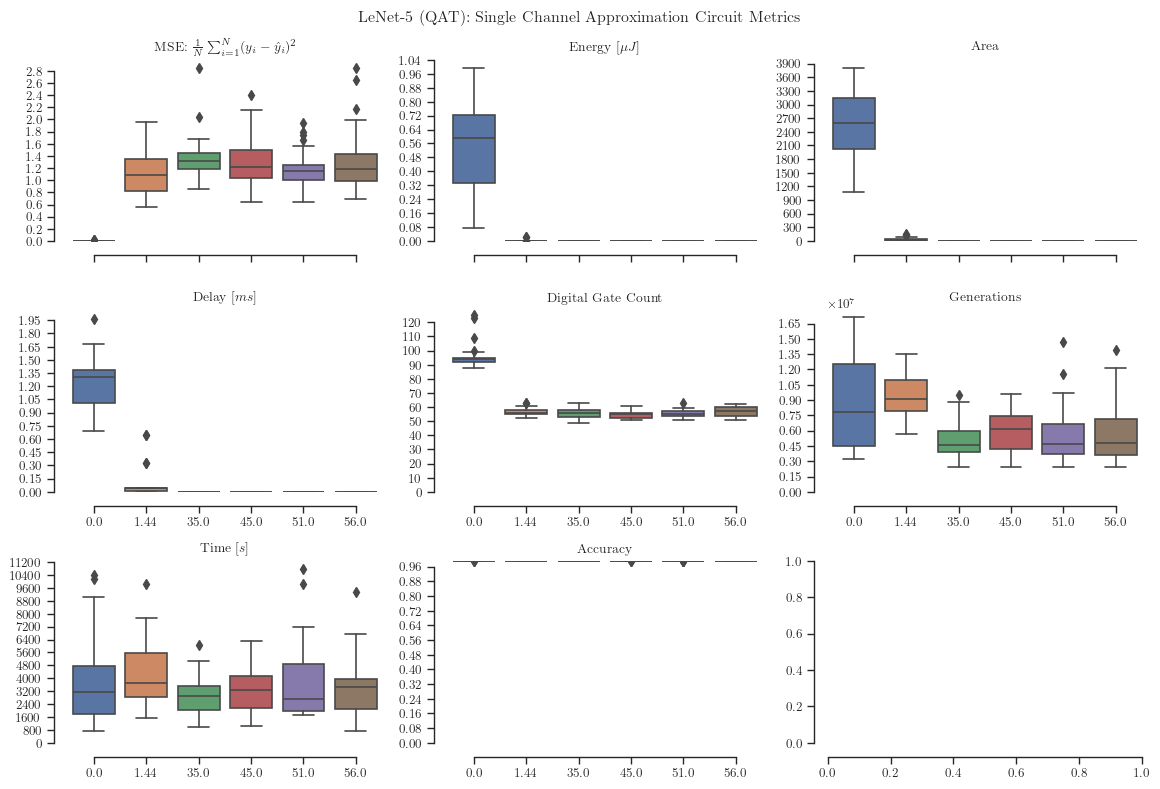

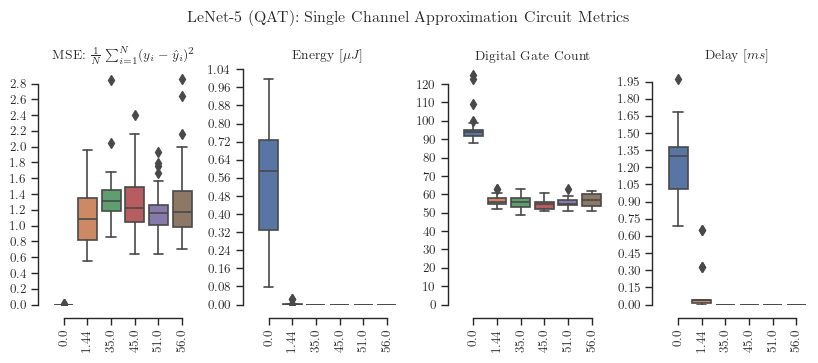

In [16]:
titles = {
    "Error": r"MSE: $\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$",
    "Energy": "Energy [$\mu J$]",
    "Area": "Area",
    "Delay": "Delay [$ms$]",
    "Gate Count": "Digital Gate Count",
    "Generation": "Generations",
    "Timestamp": "Time $[s]$",
    "Top-1": "Accuracy",
}

def plot(solutions_df, col, ax, i, sharex_index=True, landscape=False):
    tick_count = min((solutions_df["Gate Count"].max() + 1) // (2 if (col != "Gate Count") else 1), 15)
    if col == "Timestamp":
        solutions_df = solutions_df.groupby(by=["MSE Threshold", "Run"])["Timestamp"].max().reset_index()        
    g = sns.boxplot(data=solutions_df, x="MSE Threshold", y=col, ax=ax)
    g.yaxis.set_major_locator(plt.MaxNLocator(tick_count, min_n_ticks=10, integer=(col=="Gate Count")))
    g.set_ylim(0)
    g.set_title(titles[col])
    g.set_ylabel(None)
    g.set_xlabel(None)
    if not landscape:
        g.tick_params(axis="x", rotation=90)
    if i < sharex_index:
        g.axes.get_xaxis().set_ticklabels([])
        g.set_xlabel(None)
    return g    

def plot_columns(df, columns, r, c, sharex=True, landscape=False):
    fig, axes = plt.subplots(r, c, figsize=(8.27 if not landscape else 11.69, 3.65 * r if not landscape else 8))
    for col, ax, i in zip(columns, axes.flat, range(r*c)):
        plot(df, col, ax, i, c if sharex else 0, landscape=landscape)    
    return fig

for x in ["best"]:
    solutions_df = df if x == "best" else load_dfs(best_solution=False, model_acc=True, unique=True)
    fig_all = plot_columns(solutions_df, fitness_columns + ["Generation", "Timestamp", "Top-1"], 3, 3, landscape=True)
    fig_all.suptitle("LeNet-5 (QAT): Single Channel Approximation Circuit Metrics")
    sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_all)
    fig_all.tight_layout()
    fig_all.savefig(figures / f"boxplot.{x}.png")
    fig_all.savefig(figures / f"boxplot.{x}.pdf")
    fig_all.savefig(figures / f"boxplot.{x}.svg")

    fig_brief = plot_columns(solutions_df, ["Error", "Energy", "Gate Count", "Delay"], 1, 4, sharex=False)
    sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_brief)
    fig_brief.suptitle("LeNet-5 (QAT): Single Channel Approximation Circuit Metrics")
    fig_brief.tight_layout()
    fig_brief.savefig(figures / f"boxplot_{x}_brief.png")
    fig_brief.savefig(figures / f"boxplot_{x}_brief.pdf")
    fig_brief.savefig(figures / f"boxplot_{x}_brief.svg")

In [5]:
solutions_df = load_dfs(best_solution=True, model_acc=True)
non_duplicate_df = load_dfs(best_solution=True, model_acc=True, unique=True)
solutions_df["Accuracy Loss"] = (solutions_df["Ref Top-1"] - solutions_df["Top-1"]) * 100
solutions_df["Loss Delta"] = solutions_df["Ref Loss"] - solutions_df["Loss"]
solutions_df["Dataset Split"] = solutions_df["Dataset"].apply(lambda x: x.split(",")[1].strip())

In [14]:
def plot_pareto(title: str = None, layer_index: int = None, epsilon_a = 0.197, epsilon_e = 1e-5, fig=None, ax=None):
    assert fig == ax == None or fig != None and ax != None
    
    temp_df = solutions_df
    pareto = is_pareto_efficient_simple(np.vstack((temp_df["Accuracy Loss"], temp_df["Energy"])).T)
    scatter_df = temp_df.copy()
    scatter_df["Accuracy Loss"] += epsilon_a
    scatter_df["Energy"] += epsilon_e

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8.27, 3.65))

    sns.lineplot(data=scatter_df.loc[pareto, :], x="Energy", y="Accuracy Loss", linestyle="--", color="#555", lw=0.7, alpha=0.6, ax=ax)
    g = sns.scatterplot(data=scatter_df, x="Energy", y="Accuracy Loss", hue="MSE Threshold", style="Dataset Split", s=15, palette=sns.color_palette(), ax=ax)
    g.set(yscale="log", xscale="log", xlabel=r"Energy $[\mu J] + \varepsilon$", ylabel=r"Accuracy Loss $[$\%$] + \varepsilon$")
    if title:
        g.set_title(title)
    g.legend(loc="center left", bbox_to_anchor=(1.1, 0.5), ncol=1)
    sns.despine()
    return temp_df[["Accuracy Loss", "Energy"]].min()    

C:\Users\Majo\AppData\Local\Temp\ipykernel_9896\689789602.py:10: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  g = sns.swarmplot(data=solutions_df, x="MSE Threshold", y="Accuracy Loss", hue="Dataset Split", dodge=False, ax=ax[0], palette=sns.color_palette(), size=3)
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 78.2% of the points cannot be placed; 

x = |49|
y = |81|
same = |17|
x = [-127 -123  -92  -83  -77  -75  -72  -71  -69  -66  -63  -61  -59  -53
  -42  -36  -30  -25  -21  -18  -15  -11   -8   16   18   19   25   30
   36   38   44   54   60   61   63   64   67   69   79   82   89   93
  101  104  106  115  117  118  127]
y = [-127 -124 -112  -96  -92  -91  -90  -88  -81  -79  -77  -76  -64  -62
  -61  -60  -57  -56  -55  -54  -53  -49  -47  -44  -43  -39  -37  -35
  -34  -33  -32  -31  -28  -27  -26  -25  -23  -22  -21  -17  -16  -13
  -12  -11   -9   -8   -7   -5   -4   -3    4    5    6    7   11   16
   21   22   23   24   25   26   28   32   51   58   60   65   66   70
   75   76   79   82   87   90  101  102  103  118  127]
same = [-127  -92  -77  -61  -53  -25  -21  -11   -8   16   25   60   79   82
  101  118  127]


c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 82.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 16.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categori

Accuracy Loss   -0.04
Energy           0.00
dtype: float64

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 82.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 16.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\categori

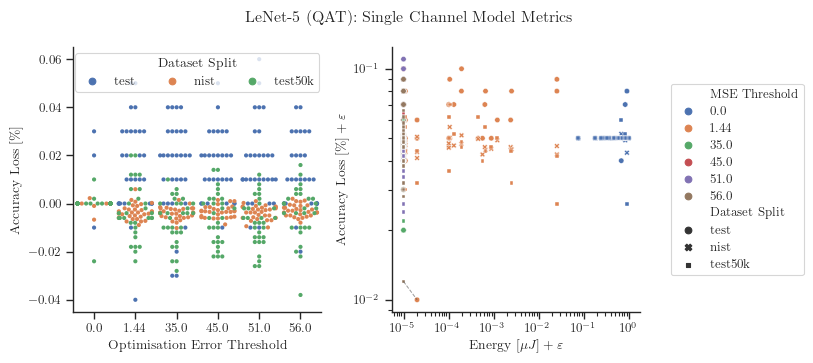

In [16]:

sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True,
})

fig, ax = plt.subplots(1, 2, figsize=(8.27, 3.65))
ax = ax.flat

# solutions_df["Approximate Error"] = 10 ** (np.round(np.emath.logn(10, solutions_df["Error"])))

g = sns.swarmplot(data=solutions_df, x="MSE Threshold", y="Accuracy Loss", hue="Dataset Split", dodge=False, ax=ax[0], palette=sns.color_palette(), size=3)
g.set(xlabel=r"Optimisation Error Threshold", ylabel=r"Accuracy Loss [$\%$]")
g.legend(loc="upper center", ncol=3, title="Dataset Split")

plot_pareto(epsilon_a=0.05, epsilon_e=1e-5, ax=ax[1], fig=fig)
# g.legend(ncol=2)

x, y = get_weights()
print(f"x = |{len(np.unique(x))}|")
print(f"y = |{len(np.unique(y))}|")
print(f"same = |{len(np.intersect1d(x, y, assume_unique=False))}|")
print(f"x = {np.unique(x)}")
print(f"y = {np.unique(y)}")
print(f"same = {np.intersect1d(x, y, assume_unique=False)}")
fig.suptitle("LeNet-5 (QAT): Single Channel Model Metrics")
fig.tight_layout()
fig.savefig(figures / "model.metrics.pdf")
solutions_df[["Accuracy Loss", "Energy"]].min()

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

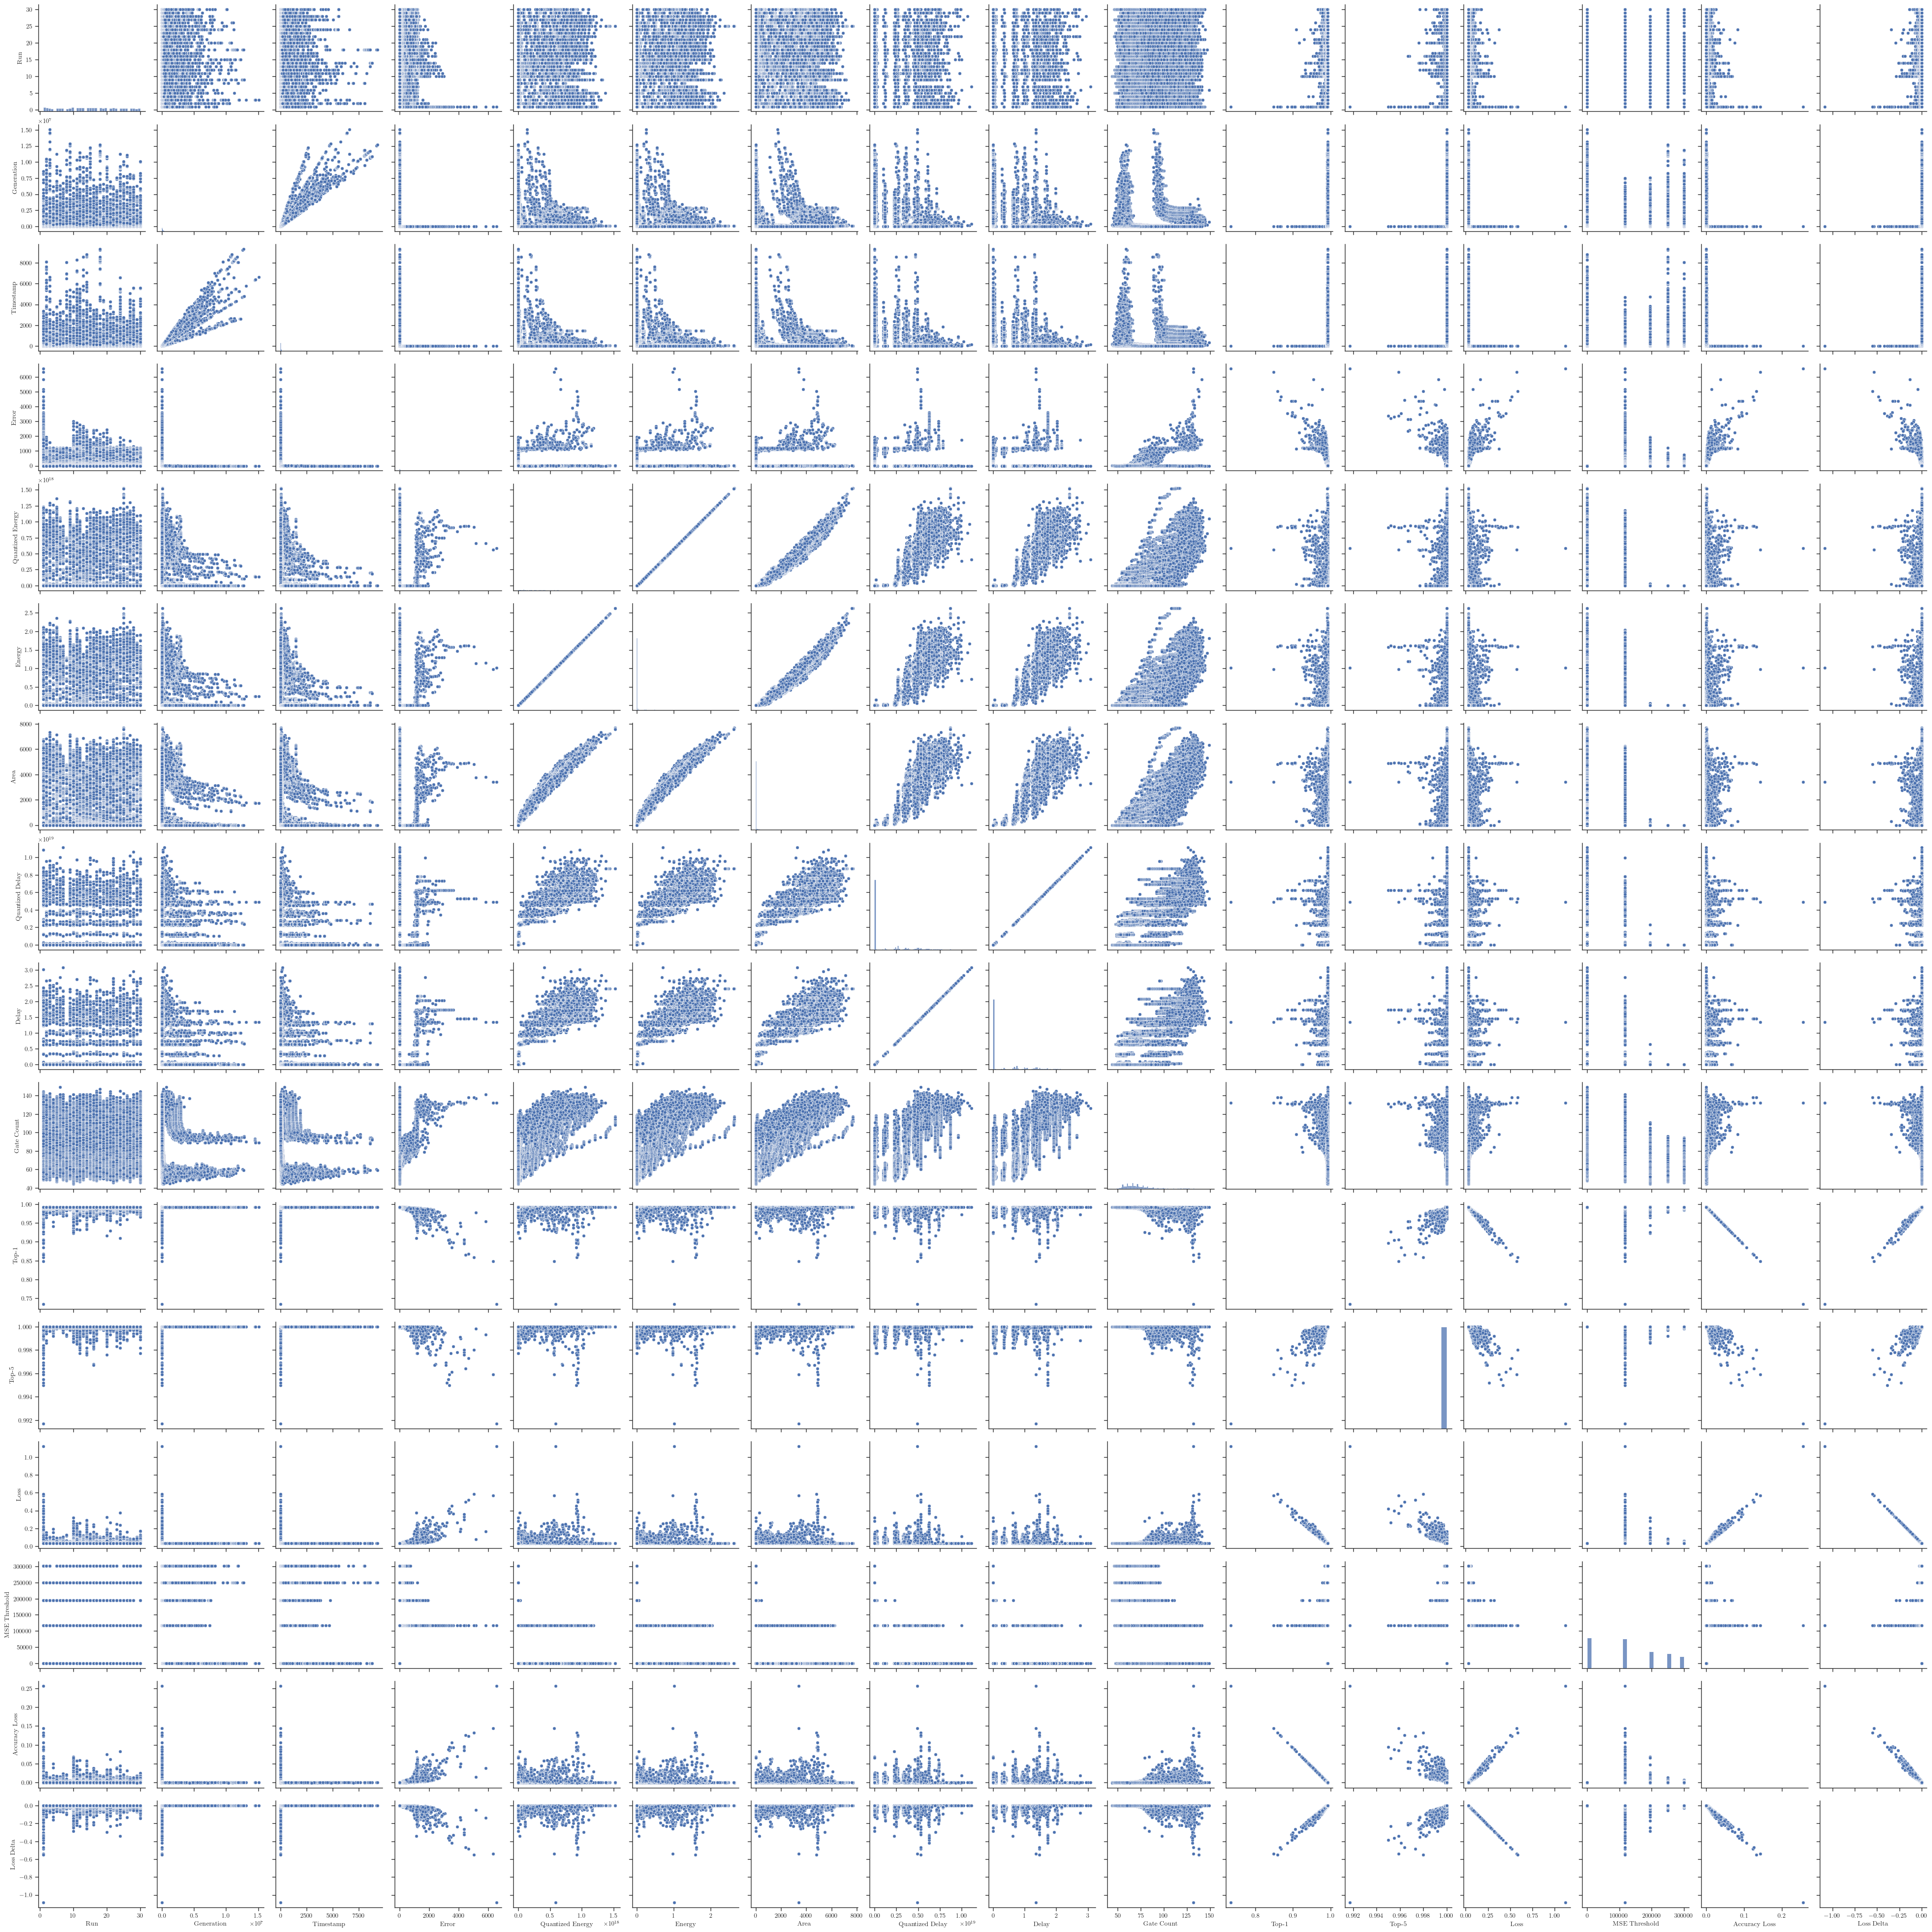

In [24]:
sns.pairplot(solutions_df)